## Session #2 Homework

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

Download data

In [2]:
# !curl https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv -o AB_NYC_2019.csv

Import data

In [3]:
data = pd.read_csv('AB_NYC_2019.csv')
print(data.shape)
data.head()

(48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


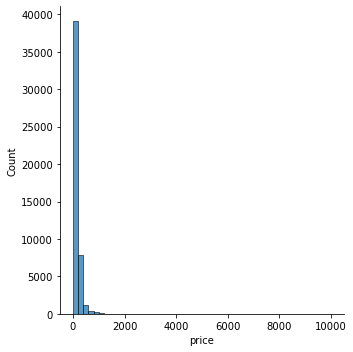

In [4]:
sns.displot(data=data, x='price', bins=50);

The price data has a long tail.

In [5]:
# subset the data
features = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
data = data[features]

---
Quesion 1: Find a feature with missing values. How many missing values does it have?

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        48895 non-null  float64
 1   longitude                       48895 non-null  float64
 2   price                           48895 non-null  int64  
 3   minimum_nights                  48895 non-null  int64  
 4   number_of_reviews               48895 non-null  int64  
 5   reviews_per_month               38843 non-null  float64
 6   calculated_host_listings_count  48895 non-null  int64  
 7   availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 3.0 MB


The feature `reviews_per_month` has missing values

In [7]:
print(f'There are {data.reviews_per_month.isnull().sum()} missing values in the feature reviews_per_month')

There are 10052 missing values in the feature reviews_per_month


---
Question 2: What's the median (50% percentile) for variable 'minimum_nights'?

In [8]:
print(f'The median for feature minimum_nights is {data.minimum_nights.median()}')

The median for feature minimum_nights is 3.0


---
#### Split the data
- Shuffle the initial dataset, use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.
- Make sure that the target value ('price') is not in your dataframe.
- Apply the log transformation to the price variable using the np.log1p() function.

In [9]:
def clean_data(df, fillna=0):
    """
    Fill missing value with fillna=0 or fillna='mean (default 0)')
    """
    if fillna == 0:
        return df.fillna(0)
    elif fillna == 'mean':
        return df.fillna(df.mean())
    else:
        print('Invalid method. Please use 0 or mean.')

def prepare_X(df, fillna=0):
    df = df.copy()    
    df_clean = clean_data(df, fillna)
    X = df_clean.values

    return X

In [10]:
np.random.seed(42) # set random seed for reproducibility

n = len(data) # length of data

n_val = int(n * 0.2) # set validation length to 20% of data
n_test = int(n * 0.2) # set test length to 20% of data
n_train = n - (n_val + n_test) # set train length to 60% of data

idx = np.arange(n) # index range
np.random.shuffle(idx) # shuffle indices

data_shuffled = data.iloc[idx] # shuffle data

# training set
df_train = data_shuffled.iloc[:n_train].copy() # split the training set 20%
y_train = np.log1p(df_train.price.values) # save targets to y (log transform)
df_train = df_train.drop('price', axis=1) # remove target from data
# validation set
df_val = data_shuffled.iloc[n_train:n_train+n_val].copy() # split the validation set 20%
y_val = np.log1p(df_val.price.values) # save targets to y (log transform)
df_val = df_val.drop('price', axis=1) # remove target from data
# test set
df_test = data_shuffled.iloc[n_val:].copy() # split the test set 60%
y_test = np.log1p(df_test.price.values) # save targets to y (log transform)
df_test = df_test.drop('price', axis=1) # remove target from data

---
#### Question 3
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

In [11]:
def train_linear_regression(X, y):
    """
    Manual implementation of linear regression
    """
    ones = np.ones(X.shape[0]) # create w0 column of ones with length of X
    X = np.column_stack([ones,X]) # add ones column to X
    XTX = X.T @ X # normal equation, X transpose dot X
    XTX_inv = np.linalg.inv(XTX) # inverse of XTX
    w = XTX_inv @ X.T @ y # calculate weights
    
    return w[0], w[1:] # return the bias term w0 and the weights

def rmse(y, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE) 
    """
    se = (y - y_pred)**2
    mse = se.mean()
    return np.sqrt(mse)


**Training set**

In [12]:
fillna = 0
X_train = prepare_X(df_train, fillna=fillna)
w0, w = train_linear_regression(X_train, y_train)
y_pred = w0 + X_train @ w

score = rmse(y_train, y_pred)
print(f'fillna = {fillna}, RMSE {np.round(score,2)}')

fillna = 0, RMSE 0.64


In [13]:
fillna = 'mean'
X_train = prepare_X(df_train, fillna=fillna)
w0, w = train_linear_regression(X_train, y_train)
y_pred = w0 + X_train @ w

score = rmse(y_train, y_pred)
print(f'fillna = {fillna}, RMSE {np.round(score,2)}')

fillna = mean, RMSE 0.64


_In this case, filling the missing values with either 0 or mean gives approximately the same RMSE score on the training set_


**Validation set**

In [14]:
fillna = 0
X_train = prepare_X(df_train, fillna=fillna)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, fillna=fillna)
y_pred = w0 + X_val @ w

score = rmse(y_val, y_pred)
print(f'fillna = {fillna}, RMSE {np.round(score,2)}')

fillna = 0, RMSE 0.64


In [15]:
fillna = 'mean'
X_train = prepare_X(df_train, fillna=fillna)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, fillna=fillna)
y_pred = w0 + X_val @ w

score = rmse(y_val, y_pred)
print(f'fillna = {fillna}, RMSE {np.round(score,2)}')

fillna = mean, RMSE 0.64


_In this case, filling the missing values with either 0 or mean gives approximately the same RMSE score on the training and validation sets_

---
#### Question 4

- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

In [16]:
def train_linear_regression_reg(X, y, r=0.001):
    """
    Manual implementation of linear regression
    """
    ones = np.ones(X.shape[0]) # create w0 column of ones with length of X
    X = np.column_stack([ones,X]) # add ones column to X
    XTX = X.T @ X # normal equation, X transpose dot X
    XTX = XTX + r * np.eye(XTX.shape[0]) # add regularization term
    XTX_inv = np.linalg.inv(XTX) # inverse of XTX
    w = XTX_inv @ X.T @ y # calculate weights
    
    return w[0], w[1:] # return the bias term w0 and the weights

In [17]:
reg_terms = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
scores = []

X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in reg_terms:    
    w0, w = train_linear_regression_reg(X_train, y_train, r)
    y_pred = w0 + X_val @ w
    score = rmse(y_val, y_pred)
    scores.append(np.round(score,2))
    
    print(r, w0, np.round(score,7))

0 -419.91265866086724 0.6430338
1e-06 -419.86271584310543 0.6430341
0.0001 -414.9764926433289 0.6430723
0.001 -375.27365274892543 0.643767
0.01 -191.7838405478213 0.6557528
0.1 -32.562560550033176 0.67733
1 -3.499216833574792 0.6823117
5 -0.7033623186161135 0.6827916
10 -0.35127676047352 0.682843


In [18]:
print('The r with the smallest RMSE score is 0 (at the sixth decimal digit)')

The r with the smallest RMSE score is 0 (at the sixth decimal digit)


#### Question 5
- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
- Round the result to 3 decimal digits (`round(std, 3)`)

>Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.

In [19]:
scores = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed) # set random seed
    
    # split the data to train, validation, test sets
    n = len(data) # length of data
    n_val = int(n * 0.2) # set validation length to 20% of data
    n_test = int(n * 0.2) # set test length to 20% of data
    n_train = n - (n_val + n_test) # set train length to 60% of data
    idx = np.arange(n) # index range
    np.random.shuffle(idx) # shuffle indices
    data_shuffled = data.iloc[idx] # shuffle data
    # training set
    df_train = data_shuffled.iloc[:n_train].copy() # split the training set 20%
    y_train = np.log1p(df_train.price.values) # save targets to y (log transform)
    df_train = df_train.drop('price', axis=1) # remove target from data
    # validation set
    df_val = data_shuffled.iloc[n_train:n_train+n_val].copy() # split the validation set 20%
    y_val = np.log1p(df_val.price.values) # save targets to y (log transform)
    df_val = df_val.drop('price', axis=1) # remove target from data
    # test set
    df_test = data_shuffled.iloc[n_val:].copy() # split the test set 60%
    y_test = np.log1p(df_test.price.values) # save targets to y (log transform)
    df_test = df_test.drop('price', axis=1) # remove target from data

    # validate the model
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression(X_train, y_train)
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val @ w
    score = rmse(y_val, y_pred)
    
    # save scores
    scores.append(score)

In [20]:
scores_std = np.std(scores)
print(f'The standard deviation for the different random seeds is: {np.round(scores_std,3)}')

The standard deviation for the different random seeds is: 0.008


---
#### Question 6
- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with `r=0.001`.
- What's the RMSE on the test dataset?

In [21]:
np.random.seed(9)

df_train_val = pd.concat([df_train, df_val]) # combine train and validation sets
y_train_val = np.concatenate([y_train, y_val]) # combine y for both sets
X_train_val = prepare_X(df_train_val)

assert len(X_train_val) == len(y_train_val) # make sure the combined X and y are of the same length

r = 0.001
w0, w = train_linear_regression_reg(X_train_val, y_train_val, r=r)

X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
score

0.644244153194359

---
Fin